In [1]:
from radial_plots import *

/cosma8/data/dp317/dc-naza3/gasCloudNfw/snap-plotting/radial_plots.py:123: RuntimeWarning: invalid value encountered in divide
  value_bin /= counts


Temperature - Original range: [0.000e+00, 6.189e+00]
Mach number - Original range: [0.000e+00, 6.189e+00]
Density - Original range: [0.000e+00, 6.327e+00]
Radial Velocity - Original range: [0.000e+00, 6.327e+00]


(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Comparison'}, xlabel='Radius [kpc]', ylabel='Normalized Value'>)

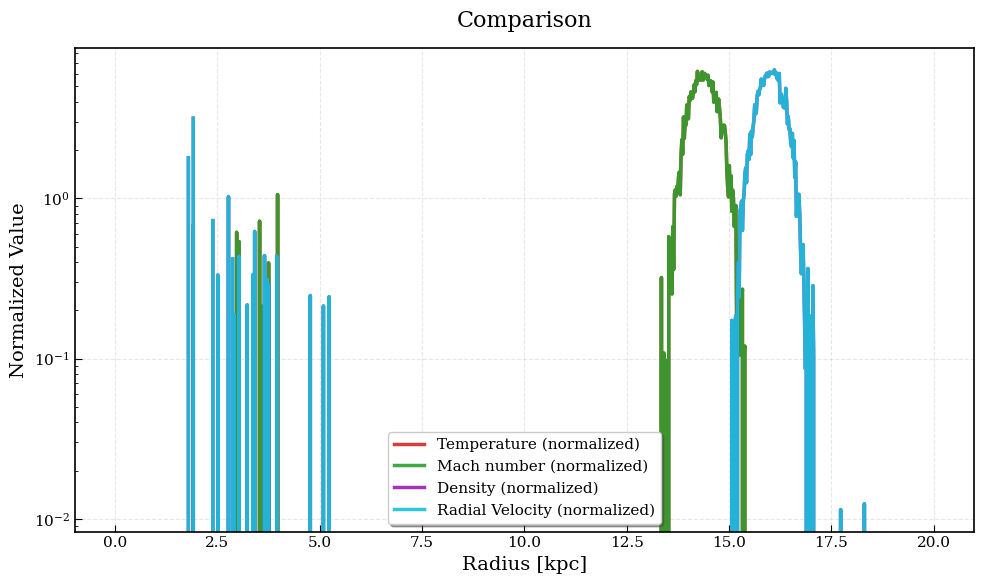

In [ ]:
o  = arun.Run(snappath='/cosma8/data/dp317/dc-naza3/gasCloudNfw/output_crexps', snapbase="snap_")
num = 2
s1  = o.loadSnap(snapnum=num)

o  = arun.Run(snappath='/cosma8/data/dp317/dc-naza3/gasCloudNfw/output2', snapbase="snap_")
num = 2
s2  = o.loadSnap(snapnum=num)

# shock_path = f'/cosma8/data/dp317/dc-naza3/gasCloudNfw/shocks_pp/shocks_{num:03d}.hdf5'
radial_range = (0, 20)  # in kpc
r_bin, temp_bin = radial_profile(s1, value='temp', radial_range=radial_range, nbins=1000)
r_bin, mach_bin = radial_profile(s1, value='mach', radial_range=radial_range, nbins=1000)

r_bin, vrad_bin = radial_profile(s2, value='temp', radial_range=radial_range, nbins=1000)
r_bin, rho_bin = radial_profile(s2, value='mach', radial_range=radial_range, nbins=1000)

plot_normalized_comparison(
                                        r_bin=r_bin,
                                        y1_values=temp_bin,
                                        y2_values=mach_bin,
                                        y1_label='Temperature',
                                        y2_label='Mach number',
                                        xlabel='Radius [kpc]',
                                        title='Comparison',
                                        logplot=True,
                                        norm=False,
                                        colors=('#d62728', '#2ca02c')  # Red and green
                                    )
plot_normalized_comparison(
                                        r_bin=r_bin,
                                        y1_values=rho_bin,
                                        y2_values=vrad_bin,
                                        y1_label='Density',
                                        y2_label='Radial Velocity',
                                        xlabel='Radius [kpc]',
                                        title='Comparison',
                                        logplot=True,
                                        norm=False,
                                        newfig=False,
                                        colors=("#9f1bb0", "#17c1db")  # Red and green
                                    )

In [10]:
def shock_region_mask(mach, preshock_offset=10, postshock_offset=10):

    max_idx = int(np.nanargmax(mach))
    start = max(0, max_idx - preshock_offset)
    end = min(len(mach), max_idx + postshock_offset + 1)
    preshock_mask = np.zeros_like(mach, dtype=bool)
    postshock_mask = np.zeros_like(mach, dtype=bool)
    postshock_mask[start:max_idx] = True
    preshock_mask[max_idx:end] = True
    
    # ratio = np.nan if (np.isnan(mean_preshock) or mean_preshock == 0) else mean_postshock / mean_preshock
    return max_idx, preshock_mask, postshock_mask

def get_mean(chosen_values, mask):
    """
    Return mean of chosen values within the given mask.
    """
    values = chosen_values[mask]

    def safe_nanmean(values):
        valid = np.isfinite(values)
        return np.mean(values[valid]) if np.any(valid) else np.nan

    mean_value = safe_nanmean(values)
    return mean_value

preshock_offset = 50
postshock_offset = 50
max_idx, preshock_mask, postshock_mask = shock_region_mask(mach_bin, preshock_offset=preshock_offset, postshock_offset=postshock_offset)
preshock_mask = preshock_mask & (mach_bin==0)
preshock_mask = preshock_mask & (mach_bin==0)
rho_pre = get_mean(rho_bin, preshock_mask)
rho_post = get_mean(rho_bin, postshock_mask)
rho_post/rho_pre

2.2519066

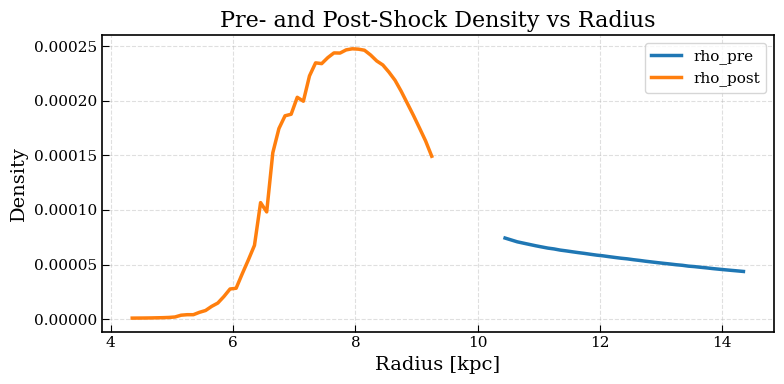

In [11]:
plt.figure(figsize=(8, 4))
plt.plot(r_bin[preshock_mask], rho_bin[preshock_mask], label='rho_pre', color='tab:blue')
plt.plot(r_bin[postshock_mask], rho_bin[postshock_mask], label='rho_post', color='tab:orange')
plt.xlabel('Radius [kpc]')
plt.ylabel('Density')
plt.title('Pre- and Post-Shock Density vs Radius')
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()

In [13]:
v_pre = get_mean(vrad_bin, preshock_mask)
v_post = get_mean(vrad_bin, postshock_mask)
(-(v_pre-vrad_bin[max_idx])/(v_post-vrad_bin[max_idx]))
# v_pre/v_post

1.0559040555932053

In [14]:
max_mach = mach_bin[max_idx]
(gamma+1)*max_mach**2/((gamma-1)*max_mach**2+2)

2.0435711539888604

In [15]:
max_mach

4.173747